In [1]:
import sys, os
sys.path = ['./scikit-learn/build/lib.linux-x86_64-3.6/', './pythia/', './pythia/codepak/cutils/'] + sys.path
os.environ['DPCOMP_CORE'] = './dpcomp_core'

from sklearn import model_selection, feature_selection
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from log_regression import test, DPLogisticRegression
from ChoiceMaker import DTChoice
import graphviz
import copy
%matplotlib inline

In [2]:
from sklearn import tree

In [3]:
from dpcomp_core.algorithm import *
from dpcomp_core.algorithm.dawa import l1partition
from dpcomp_core.query_nd_union import ndRangeUnion
from dpcomp_core import workload
from dpcomp_core import experiment
from dpcomp_core import metric
from dpcomp_core import dataset
import p_helper
import codepak.l1partition

import pickle

In [21]:
class Data:
    def __init__(self, data, dom_size, scale, wktype, eps):
        if(isinstance(data, dataset.Dataset)):
            x = np.around(data.payload)
        else:
            x = np.array(data)
        self.x = x
        self.dom_size = dom_size
        self.scale = scale
        if(wktype):
            self.Q = workload.Prefix1D(domain_shape_int=dom_size)
        else:
            self.Q = workload.Identity((dom_size,))
        self.wkload_type = wktype
        self.epsilon = eps 
    @classmethod
    def from_name(cls, dbname, dom_size, scale, wktype, eps):
        x = dataset.DatasetSampledFromFile(nickname=dbname,
            sample_to_scale=int(scale), reduce_to_dom_shape=int(dom_size),
            seed=12345)
        return cls(x, dom_size, scale, wktype, eps)
class HistAlgo:
    def __init__(self, name, seed=12345):
        self.S = np.random.RandomState(seed)
        self.name = name

    def error(self, data):
        R = self._alg.Run(data.Q, data.x, data.epsilon, self.S.randint(2**32))
        return np.linalg.norm(R-data.x)

    def run(self, data):
        R = self._alg.Run(data.Q, data.x, data.epsilon, self.S.randint(2**32))
        return R

In [149]:
class Dawa(HistAlgo):
    def __init__(self, seed=12345):
        self._alg = dawa.dawa_engine()
        super().__init__("DAWA", seed)

class Identity(HistAlgo):
    def __init__(self, seed=12345):
        self._alg = identity.identity_engine()
        super().__init__("Id", seed)

#We don't use this algorithm; haha
class Hb(HistAlgo):
    def __init__(self):
        self._alg = HB.HB_engine()
        super().__init__("Hb")
hist_list = {'Dawa': Dawa(), 'Laplace': Identity()}

class Oracle(HistAlgo):
    def __init__(self):
        self._dawa = Dawa()
        self._id = Identity()
    def run(self, data):
        E1 = self._dawa.error(data)
        E2 = self._id.error(data)
        R1 = self._dawa.run(data)
        R2 = self._id.run(data)
        if E1 < E2:
            return R1
        else:
            return R2

In [150]:
db = Data.from_name('ADULT', 2048, 512, False, 1.0)

In [161]:
db = Data(np.array([5,5]), 2, 1000, False, 1.0)

In [164]:
np.array([Dawa(s).run(db) for s in range(500)])[:, 0].std()

1.7057992222332847

In [165]:
np.array([Identity(s).run(db) for s in range(500)])[:, 0].std()

1.3368378563128098

In [103]:
Identity().error(db)

63.499419064560442

In [23]:
#Goal: See if algorithm runs are consistent with what Pythia sent us!
scale=8192
dom_size=4096
epsilon=.0875

In [351]:
dfadult1 = pickle.load(open('NaiveBayes/alg_errors/e1.0/ADULTFRANK.I.2048.pkl', 'rb'), encoding='bytes')

In [394]:
arr = []
for scale in [128, 256, 512, 1024, 2048, 4096]:
    dfadult = pickle.load(open('NaiveBayes/alg_errors/e' + str(1.0) + '/ADULTFRANK.I.' + str(scale) + '.pkl', 'rb'), encoding='bytes')
    arr.append([ dfadult[b'Dawa'][x][b'avg'] for x in dfadult1[b'Dawa'].keys() ])
arr = np.array(arr)

In [395]:
arr

array([[  3.59781237,   4.45366073,  14.05168212,  22.56771436,
          9.53966101,  18.25991306,   5.05213754,  20.93667696,
          4.91903147,  20.99330563,  20.6211817 ,  20.65333863,
         20.96810892,  21.29078877,   7.08089547,  20.75566573,
         24.10082913,  23.63002485,  24.1881462 ,  12.18850302],
       [  2.56311373,   3.22242373,  13.69850364,  28.09861251,
          6.96617892,  17.29579732,   2.64564227,  21.32614446,
          4.06063204,  22.49227604,  21.69146603,  21.2385045 ,
         21.31425784,  22.02324868,   5.43769437,  21.43424699,
         29.4634015 ,  25.88221849,  26.30392612,  10.86259717],
       [  3.055585  ,   2.22542103,  13.0013173 ,  35.39695521,
          8.12675517,  17.89440292,   3.19648754,  27.10722488,
          3.75692427,  24.64765441,  25.45953766,  24.9363976 ,
         26.24262659,  25.11354229,   5.59079555,  25.35606316,
         39.42458203,  32.22661755,  35.25520423,   9.51583489],
       [  4.58166611,   5.66307527,  

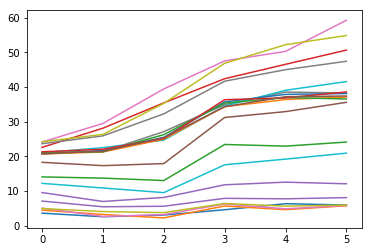

In [403]:
plt.plot(arr)

In [105]:
dfadult1[b'Laplace'].keys()

dict_keys([32, 64, 4096, 262144, 1024, 8192, 128, 524288, 256, 16384, 4194304, 2097152, 8388608, 1048576, 512, 16777216, 131072, 32768, 65536, 2048])

In [106]:
dfadult1[b'Dawa'][256]

{b'all': [],
 b'avg': 5.625782268768063,
 b'yerr': array([ 1.28758946,  0.8536528 ])}

In [107]:
dfadult1[b'Laplace'][256]

{b'all': [],
 b'avg': 63.736107805382574,
 b'yerr': array([ 1.06448977,  0.88103967])}

In [79]:
dfadult1[b'Dawa'][8388608]

{b'all': [],
 b'avg': 35.334705987028613,
 b'yerr': array([ 2.29608369,  1.51453763])}

In [46]:
class HistMetafeats:
    def __init__(self, seed=12345):
        self.S = np.random.RandomState(seed)
        self.sensitivities = {'scale': 0, 'shape': 0, 'nnz': 1, 'tvd': 2, 'partition': 2}
    @staticmethod
    def dev(H):
        return np.linalg.norm(H-H.mean(), ord=1)
    def min_cost(self, H):
        dw_part = codepak.l1partition.L1partition_true(H.astype('int32'), 1, 0.3, gethist=False)
        return p_helper.pcost(dw_part, H, 0.7)
    def __call__(self, data):
        if(isinstance(data.x, dataset.DatasetSampledFromFile)):
            x = data.x.payload
        else:
            x = data.x
        #Instead of having epsilon be a metafeature, multiply database histogram
        #by epsilon and pretend epsilon=1. Verify that all metafeatures will
        #the same relative noise added to them
        H = np.around(x*data.epsilon).astype('int')
        nnz = np.count_nonzero(H)
        tvd = HistMetafeats.dev(H)
        cost = self.min_cost(H)
        return {'scale': data.scale, 'shape': data.dom_size,
                             'nnz': nnz, 'tvd': tvd, 'partition': cost}

In [47]:
prng = np.random.RandomState(12246)
scales=np.power(2, np.arange(5, 25))
dom_sizes = np.power(2, np.arange(7, 13))
epsilon=1

In [387]:
#cms = [nb_cm_adult, nb_cm_hepth, nb_cm_income, nb_cm_medcost, nb_cm_nettrace, nb_cm_patent, nb_cm_searchlogs]
#pickle.dump(cms, open('NaiveBayes/choicemakers/all_cm.pkl', 'wb'))
cms = pickle.load(open('NaiveBayes/choicemakers/all_cm.pkl', 'rb'))

EOFError: Ran out of input

In [48]:
regrets_avg = []
feats = []
filenames = ['ADULTFRANK', 'INCOME', 'MEDCOST', 'NETTRACE', 'PATENT', 'SEARCHLOGS']
dsizes = [128, 256, 512, 1024, 2048, 4096] #We didn't include 8192 because reshaping takes too long!
scales = np.power(2, np.add(range(20), 5))
epsilon = 1.0
for f in filenames:
    for k in dsizes:
        print(len(regrets_avg))
        with open('NaiveBayes/alg_errors/e' + str(epsilon) + '/' + 
                 f + '.I.' + str(k) + '.pkl', 'rb') as input:
            D = pickle.load(input, encoding='bytes')
            for scale in scales:
                regrets_avg.append({'Laplace': D[b'Laplace'][scale][b'avg'], 'Dawa': D[b'Dawa'][scale][b'avg']})
            
            input.close()
        x = np.load('dpcomp_core/datafiles/1D/' + f + '.n4096.npy')
        x = p_helper.change_size(x, k)
        for scale in scales:
            x = np.divide(x, float(sum(x))/scale, dtype=float)
            dw_part = codepak.l1partition.L1partition_true(x.astype('int32'), 1, 0.3, gethist=False)
            dw_score = p_helper.pcost(dw_part, x, 0.7)
            tvd = np.linalg.norm(x-x.mean(), ord=1)
            
            feats.append({'db': f, 'scale': scale, 'domsize': k, 'nnz': np.count_nonzero(x),
                          'tvd': tvd, 'partition': dw_score})

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700


In [49]:
feats = pd.DataFrame(feats)
regrets_avg = pd.DataFrame(regrets_avg)
big_cm = DTChoice(feats.drop('db', axis=1), HistMetafeats(), hist_list, regrets=regrets_avg / regrets_avg.max())

In [50]:
Xs = pd.concat(obj.X for obj in cms).reset_index(drop=True)
ys = pd.concat(obj.y for obj in cms).reset_index(drop=True)
regrets = pd.concat(obj.regrets for obj in cms).reset_index(drop=True).drop('hb', axis=1)
big_cm = DTChoice(Xs, HistMetafeats(), hist_list, regrets=regrets)

NameError: name 'cms' is not defined

In [337]:
big_cm.C = 0
big_cm.model = DecisionTreeClassifier(min_samples_leaf=10, max_depth=5)
big_cm.retrain_model()

In [338]:
big_cm.regrets.mean(axis=0)

Dawa       0.226662
Laplace    0.491427
dtype: float64

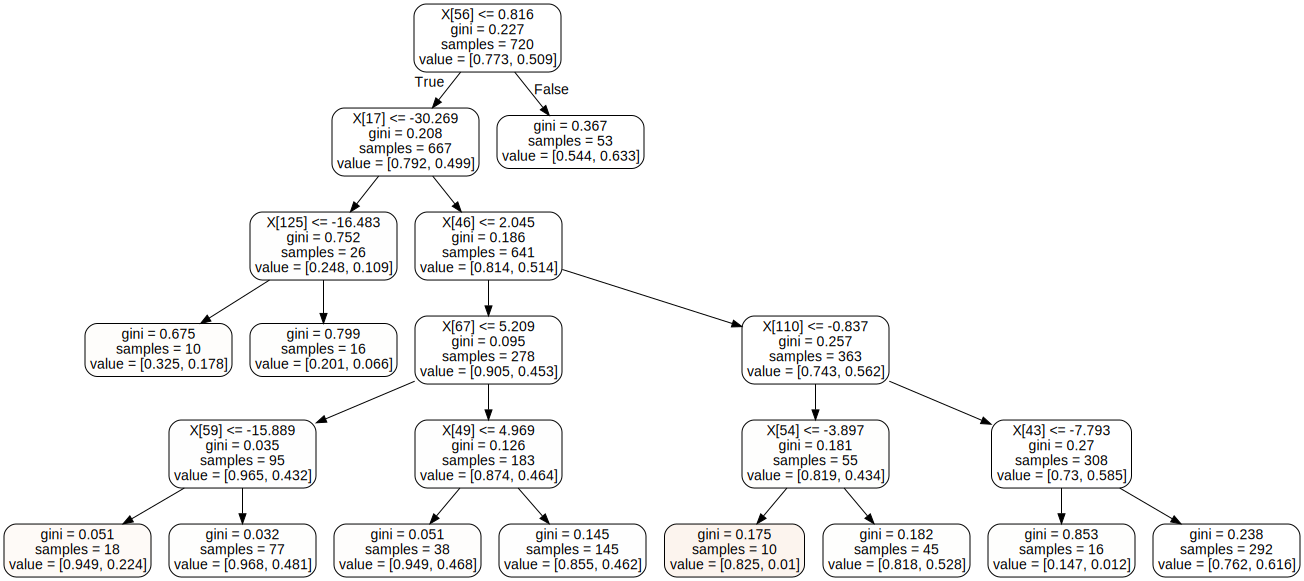

In [339]:
dot_data = export_graphviz(big_cm.model, out_file = None, filled=True, rounded=True)
graph = graphviz.Source(dot_data)
graph

In [340]:
#Run on credit card default dataset
skin = pd.read_csv('data/Skin.csv', sep='\t', header=None)
skin = skin.apply(lambda x: x-x.min())
skin[3] = skin[3].astype('category')
skin_shape = skin.apply(pd.Series.nunique)

In [341]:
default = pd.read_csv('data/default.csv', header=1)
default = default.apply(lambda x: x-x.min())
default = default.drop('ID', axis=1)
default['default payment next month'] = default['default payment next month'].astype('category')
#default.apply(pd.Series.nunique)

In [342]:
def PrivateNaiveBayes(db, test, budget, shape, choicemaker=None, alg=None, prng=None):
    k = len(db.columns)
    epsilon = budget/k
    y_name = db.columns[-1]
    ys = db[y_name]
    [i0, i1] = db[y_name].cat.categories
    if prng is None:
        prng = np.random.RandomState()
    ys_prob = Data(pd.value_counts(ys).sort_index(), shape[db.columns[-1]], len(ys), False, epsilon)
    if choicemaker is None:
        Hy = alg[0].run(ys_prob)
    else:
        Hy = choicemaker.choose(ys_prob)
    #Hy = get_hist(ys, epsilon, prng, shape[db.columns[-1]])
    Hy /= Hy.sum()

    total_probs0 = np.repeat(Hy[i0], len(test))
    total_probs1 = np.repeat(Hy[i1], len(test))
    num_zeros = (ys == i0).sum()
    num_ones = (ys == i1).sum()
    for c in db.columns[:-1]:
        cnts = pd.value_counts(db[ys == i0][c])
        hist0 = np.zeros(shape[c], dtype='int32')
        hist0[cnts.index] += cnts
        col0_hist = Data(hist0, shape[c], num_zeros, False, epsilon)
        if choicemaker is None:
            histx0 = alg[1].run(col0_hist)
        else:
            histx0 = choicemaker.choose(col0_hist)
        total_probs0 *= histx0[test[c]] / histx0.sum()

        cnts = pd.value_counts(db[ys == i1][c])
        hist1 = np.zeros(shape[c], dtype='int32')
        hist1[cnts.index] += cnts
        col1_hist = Data(hist1, shape[c], num_ones, False, epsilon)
        if choicemaker is None:
            histx1 = alg[1].run(col1_hist)
        else:
            histx1 = choicemaker.choose(col1_hist)
        total_probs1 *= histx1[test[c]] / histx1.sum()
    return total_probs0 / (total_probs1 + total_probs0)

In [343]:
from sklearn.metrics import roc_auc_score

In [349]:
def run_tests(db, db_shape, big_cm, eps):
    perfs = []
    for y in range(0, 20):
        for x in [1000, 10000, 100000]:
            half = int(x/2)
            perf_size={'size' : x}
            train = db.sample(half, replace=True).reset_index(drop=True)
            test = db.sample(half, replace=True).reset_index(drop=True)
            probs = PrivateNaiveBayes(train, test, eps, db_shape, big_cm)
            perf_size['cm'] = roc_auc_score(test[3], probs)
            for name, alg in hist_list.items():
                probs = PrivateNaiveBayes(train, test, eps, db_shape, alg=[alg, alg])
                perf_size[name] = roc_auc_score(test[3], probs)
            #probs = PrivateNaiveBayes(train, test, eps, db_shape, alg=Oracle())
            probs = PrivateNaiveBayes(train, test, eps, db_shape, alg=[hist_list['Laplace'], hist_list['Dawa']])
            perf_size['oracle'] = roc_auc_score(test[3], probs)
            perfs.append(perf_size)
    return pd.DataFrame(perfs)

In [348]:
db = skin
db_shape = skin_shape
budget = 0.05
shape=skin_shape
for y in range(0, 20):
    for x in [1000, 10000, 1000000]:
        half = int(x/2)
        train = db.sample(half, replace=False).reset_index(drop=True)
        test = db.sample(half, replace=False).reset_index(drop=True)
        db2 = train
        k = len(db.columns)
        epsilon = budget/k
        y_name = db2.columns[-1]
        ys = db2[y_name]
        [i0, i1] = db2[y_name].cat.categories
        prng = np.random.RandomState()
        ys_prob = Data(pd.value_counts(ys).sort_index(), shape[db2.columns[-1]], len(ys), False, epsilon)
        for key, alg in hist_list.items():
            print(key), 
            print( np.linalg.norm( alg.run(ys_prob) - ys_prob.x))
        print()

Dawa
53.0301012937
Laplace
100.569463994

Dawa
45.8288960758
Laplace
119.885949334

Dawa
136.122880903
Laplace
86.2228535224

Dawa
618.118049255
Laplace
363.745122532

Dawa
547.552220184
Laplace
257.928244702

Dawa
287.208280366
Laplace
39.3180270947

Dawa
503.170337527
Laplace
204.381063101

Dawa
300.151294911
Laplace
274.347003944

Dawa
66.6001307219
Laplace
43.0805093426

Dawa
130.480633753
Laplace
90.0643821943

Dawa
412.298066458
Laplace
196.567822505

Dawa
666.672197212
Laplace
133.918409291

Dawa
241.960427892
Laplace
205.060038189

Dawa
154.698967633
Laplace
18.0801913135

Dawa
156.994971897
Laplace
135.351919404

Dawa
255.384644984
Laplace
41.3113657184

Dawa
1122.47096135
Laplace
86.3059582037

Dawa
207.216847011
Laplace
79.5199296074

Dawa
99.3037348948
Laplace
166.475809953

Dawa
55.6834605112
Laplace
169.615594622

Dawa
112.793067738
Laplace
36.5465999927

Dawa
210.50064987
Laplace
100.592816159

Dawa
300.088287362
Laplace
64.6493539957

Dawa
236.173917728
Laplace
85.30409

In [350]:
perfs = run_tests(skin, skin_shape, big_cm, 0.2)
perfs.groupby('size').mean()

,Dawa,Laplace,cm,oracle
size,,,,
1000,0.445154,0.504931,0.501988,0.426283
10000,0.109545,0.404020,0.432130,0.103446
100000,0.033070,0.132832,0.172806,0.035407


In [ ]:
perfs2 = run_tests(default, big_cm)

In [186]:
hist_list

{'Dawa': <__main__.Dawa at 0x7ff49b036da0>,
 'Laplace': <__main__.Identity at 0x7ff49b036438>}

In [ ]:
skin.apply(pd.Series.nunique)

In [ ]:
db = skin.sample(1000, replace=True).reset_index(drop=True)
y_name = db.columns[-1]
ys = db[y_name]
x = dataset.Dataset(np.array(pd.value_counts(ys).sort_index()))
ys_prob = Data(x, shape[db.columns[-1]], len(ys), False, epsilon)
R1, R2 = Oracle().run(ys_prob)

In [ ]:
pd.value_counts(ys).sort_index()

In [ ]:
big_cm.X.columns